In [1]:
import pandas as pd

# Read the train and test files
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

#Quick checks
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (3807, 13)
X_test shape: (952, 13)
y_train shape: (3807, 1)
y_test shape: (952, 1)


In [2]:
#Extracted X_train, X_test, y_train and y_test from pre_processing notebook
#prior to standardization and log transformation of numeric features
#so repeating steps here

from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize 'NewBasePrice' 
scaler = StandardScaler()
X_train['NewBasePrice'] = scaler.fit_transform(X_train[['NewBasePrice']])
X_test['NewBasePrice'] = scaler.transform(X_test[['NewBasePrice']])

# Log-transform 'SellingStoresRatio' 
# Add a small constant to avoid log(0)
X_train['SellingStoresRatio'] = np.log(X_train['SellingStoresRatio'] + 1e-6)
X_test['SellingStoresRatio'] = np.log(X_test['SellingStoresRatio'] + 1e-6)


In [3]:
# import packages
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.pipeline import Pipeline

# Ensure y is 1D 
def _to_1d(y):
    if isinstance(y, pd.DataFrame):
        if y.shape[1] == 1:
            return y.iloc[:, 0]
        else:
            raise ValueError("y has multiple columns; please provide a single target column.")
    return y.squeeze()

y_train_1d = _to_1d(y_train)
y_test_1d  = _to_1d(y_test)

# CONFIG
RANDOM_STATE = 42
CV_FOLDS = 5
cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
SCORING = "neg_root_mean_squared_error"

# MODELS & PARAM GRIDS 
models = {}

# 1) Linear Regression (no tuning)
models["LinearRegression"] = Pipeline(steps=[
    ("model", LinearRegression())
])

# 2) Ridge
ridge_grid = {"model__alpha": np.logspace(-3, 3, 13)}
models["Ridge"] = GridSearchCV(
    Pipeline([("model", Ridge(random_state=RANDOM_STATE))]),
    param_grid=ridge_grid, cv=cv, scoring=SCORING, n_jobs=-1
)

# 3) Lasso
lasso_grid = {"model__alpha": np.logspace(-4, 1, 13)}
models["Lasso"] = GridSearchCV(
    Pipeline([("model", Lasso(random_state=RANDOM_STATE, max_iter=10000))]),
    param_grid=lasso_grid, cv=cv, scoring=SCORING, n_jobs=-1
)

# 4) Random Forest
rf_grid = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5],
    "model__max_features": ["sqrt", 0.5, None],
}
models["RandomForest"] = GridSearchCV(
    Pipeline([("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))]),
    param_grid=rf_grid, cv=cv, scoring=SCORING, n_jobs=-1
)

# 5) Gradient Boosting
gbr_grid = {
    "model__n_estimators": [200, 500],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 5],
    "model__subsample": [0.7, 1.0],
}
models["GradientBoosting"] = GridSearchCV(
    Pipeline([("model", GradientBoostingRegressor(random_state=RANDOM_STATE))]),
    param_grid=gbr_grid, cv=cv, scoring=SCORING, n_jobs=-1
)

# 6) KNN Regressor
knn_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "model__weights": ["uniform", "distance"],
}
models["KNNRegressor"] = GridSearchCV(
    Pipeline([("model", KNeighborsRegressor())]),
    param_grid=knn_grid, cv=cv, scoring=SCORING, n_jobs=-1
)

# TRAIN, EVALUATE, COLLECT RESULTS
def evaluate(trained_estimator, X_tr, y_tr, X_te, y_te, model_name=""):
    yhat_tr = trained_estimator.predict(X_tr)
    yhat_te = trained_estimator.predict(X_te)
    rmse_tr = mean_squared_error(y_tr, yhat_tr, squared=False)
    rmse_te = mean_squared_error(y_te, yhat_te, squared=False)
    mae_tr  = mean_absolute_error(y_tr, yhat_tr)
    mae_te  = mean_absolute_error(y_te, yhat_te)
    r2_tr   = r2_score(y_tr, yhat_tr)
    r2_te   = r2_score(y_te, yhat_te)
    return {
        "model": model_name,
        "rmse_train": rmse_tr,
        "rmse_test": rmse_te,
        "mae_train": mae_tr,
        "mae_test": mae_te,
        "r2_train": r2_tr,
        "r2_test": r2_te,
    }

results = []
best_params_lookup = {}

for name, est in models.items():
    print(f"\n=== Fitting {name} ===")
    est.fit(X_train, y_train_1d)

    if isinstance(est, GridSearchCV):
        best_params_lookup[name] = est.best_params_
        print("Best params:", est.best_params_)
        print("Best CV score (neg RMSE):", est.best_score_)
        fitted = est.best_estimator_
    else:
        fitted = est

    results.append(evaluate(fitted, X_train, y_train_1d, X_test, y_test_1d, model_name=name))


=== Fitting LinearRegression ===

=== Fitting Ridge ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Best params: {'model__alpha': 3.1622776601683795}
Best CV score (neg RMSE): -38.383020611288444

=== Fitting Lasso ===
Best params: {'model__alpha': 0.012115276586285889}
Best CV score (neg RMSE): -38.383800312774916

=== Fitting RandomForest ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

Best params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 200}
Best CV score (neg RMSE): -23.23935742665646

=== Fitting GradientBoosting ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}
Best CV score (neg RMSE): -24.188174555838586

=== Fitting KNNRegressor ===
Best params: {'model__n_neighbors': 15, 'model__weights': 'distance'}
Best CV score (neg RMSE): -25.288105791071388


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

In [5]:
# RESULTS TABLE 
results_df = pd.DataFrame(results).sort_values(by="rmse_test")
print("\n=== Model Comparison (sorted by RMSE_test, lower is better) ===")
print(results_df.to_string(index=False))

if best_params_lookup:
    print("\n=== Best Hyperparameters (per tuned model) ===")
    for k, v in best_params_lookup.items():
        print(k, "->", v)


=== Model Comparison (sorted by RMSE_test, lower is better) ===
           model  rmse_train  rmse_test  mae_train  mae_test  r2_train  r2_test
    RandomForest   15.294698  29.189361   6.898035 10.775594  0.915480 0.731266
    KNNRegressor    0.182286  29.934731   0.009719 11.255149  0.999988 0.717366
GradientBoosting   19.078795  31.191400  10.017139 12.247399  0.868484 0.693138
           Lasso   38.501148  42.558063  23.312774 23.639246  0.464420 0.428736
           Ridge   38.500724  42.558779  23.317583 23.642985  0.464431 0.428717
LinearRegression   38.500133  42.559347  23.331681 23.653237  0.464448 0.428701

=== Best Hyperparameters (per tuned model) ===
Ridge -> {'model__alpha': 3.1622776601683795}
Lasso -> {'model__alpha': 0.012115276586285889}
RandomForest -> {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 200}
GradientBoosting -> {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, '

In [6]:
# Feature importances for tree models 
def show_tree_importances(best_estimator):
    model = best_estimator
    if isinstance(model, Pipeline):
        model = model.named_steps.get("model", model)
    importances = getattr(model, "feature_importances_", None)
    if importances is None:
        print("No feature_importances_ available for this estimator.")
        return
    imp_df = pd.DataFrame({"feature": X_train.columns, "importance": importances}) \
                .sort_values("importance", ascending=False)
    print(imp_df.head(20).to_string(index=False))

print("\nTop importances (RandomForest):")
if isinstance(models["RandomForest"], GridSearchCV):
    show_tree_importances(models["RandomForest"].best_estimator_)
else:
    show_tree_importances(models["RandomForest"])

print("\nTop importances (GradientBoosting):")
if isinstance(models["GradientBoosting"], GridSearchCV):
    show_tree_importances(models["GradientBoosting"].best_estimator_)
else:
    show_tree_importances(models["GradientBoosting"])



Top importances (RandomForest):
           feature  importance
SellingStoresRatio    0.662519
             T_YXX    0.154440
      NewBasePrice    0.103229
            S_yo2Z    0.027133
            S_Mm5P    0.021038
            S_WeHS    0.011290
            S_Aunz    0.007137
            S_xdDe    0.005067
            S_OzTP    0.002434
            S_sldf    0.002121
            S_UIpu    0.001891
            S_qE16    0.001315
            S_8qIm    0.000387

Top importances (GradientBoosting):
           feature  importance
SellingStoresRatio    0.830777
            S_yo2Z    0.067849
            S_Mm5P    0.040740
      NewBasePrice    0.029189
            S_WeHS    0.015914
             T_YXX    0.006672
            S_xdDe    0.006401
            S_Aunz    0.001681
            S_UIpu    0.000429
            S_sldf    0.000323
            S_OzTP    0.000017
            S_8qIm    0.000007
            S_qE16    0.000000


### FINDINGS FROM MODELING

Random Forest is the best model, achieving the lowest test RMSE (29.19) and the highest test R² (0.73) — meaning it explains ~73% of the variance in the SalesQuantity data on unseen samples.

Its train vs. test RMSE gap (15.3 → 29.2) suggests a bit of overfitting (normal for RF), but not excessive.

The KNN Regressor looks suspiciously overfit — near-perfect training fit (RMSE ≈ 0.18) but similar test RMSE to Random Forest → classic sign of memorization, not generalization.

Gradient Boosting performs well but not better than Random Forest.

Linear, Ridge, and Lasso all perform nearly identically (as expected), showing they can’t capture the non-linear patterns.

#### Specif findings from Random Forest

SellingStoresRation (or distribution) - By far the most influential driver of SalesQuantity — suggesting that distribution reach or store presence is the key determinant of sales. Small changes here have the largest predicted impact.

YXX terrirory -  2nd largest driver but much lower in importance vs. distribution, likely because it is the larger of the two territories.  Changes to distribution and price will have a higher impact in this territory.

NewBasePrice - while price did not appear correlated to SalesQuantity in pre-processing and EDA, in modelling - price still matters.  It is third-tier in predictive strength — meaning sales are more sensitive to availability/distribution than price in your data.

## PREDICTIONS

In [8]:
# CALCULATE IMPACT OF A 10% INCREASE IN SellingsStoreRatio
# but capping upper limit to 1.0  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config: must match your earlier preprocessing ---
EPS = 1e-6  # the same constant you used when doing np.log(x + EPS)

# --- Trained model ---
best_rf = models["RandomForest"].best_estimator_

# --- Baseline predictions (as Series for alignment) ---
y_pred_base = pd.Series(best_rf.predict(X_test), index=X_test.index, name="Pred_Base")

# --- Recover original ratio from log, apply +10%, cap at 1.0, then re-log ---
X_test_up = X_test.copy()

# 1) invert log: ratio ≈ exp(log_ratio) - EPS
ratio_orig = np.exp(X_test_up["SellingStoresRatio"]) - EPS
# numeric safety + bounds (original ratio should be in [0,1])
ratio_orig = np.clip(ratio_orig, 0.0, 1.0)

# 2) apply +10% and cap at 1.0
ratio_up = np.clip(ratio_orig * 1.10, 0.0, 1.0)

# 3) transform back to the logged feature
X_test_up["SellingStoresRatio"] = np.log(ratio_up + EPS)

# --- Scenario predictions ---
y_pred_up = pd.Series(best_rf.predict(X_test_up), index=X_test.index, name="Pred_10pctUp")

# --- Impact calculations ---
delta = (y_pred_up - y_pred_base).rename("Abs_Lift")
pct_change = pd.Series(
    np.where(y_pred_base != 0, (delta / y_pred_base) * 100, np.nan),
    index=X_test.index, name="Pct_Lift"
)

summary = pd.concat([y_pred_base, y_pred_up, delta, pct_change], axis=1)

print("=== Impact Summary (10% distribution lift, clipped at 1.0) ===")
print("Average Predicted SalesQuantity (Current):", round(y_pred_base.mean(), 2))
print("Average Predicted SalesQuantity (+10% Stores):", round(y_pred_up.mean(), 2))
print("Average Absolute Lift:", round(delta.mean(), 2))
print("Average % Lift:", round(pct_change.mean(skipna=True), 2), "%")

=== Impact Summary (10% distribution lift, clipped at 1.0) ===
Average Predicted SalesQuantity (Current): 35.21
Average Predicted SalesQuantity (+10% Stores): 38.29
Average Absolute Lift: 3.08
Average % Lift: 8.64 %


In [9]:
print("\nTop 10 highest absolute lifts:")
print(summary.sort_values(by="Abs_Lift", ascending=False).head(10))


Top 10 highest absolute lifts:
      Pred_Base  Pred_10pctUp   Abs_Lift   Pct_Lift
615  154.862455    226.217977  71.355522  46.076709
345  166.175910    226.094761  59.918850  36.057483
621  239.909651    292.876281  52.966631  22.077741
902   57.464906    107.414041  49.949135  86.921111
30   221.264034    264.238753  42.974718  19.422369
282   81.050722    121.630460  40.579738  50.067090
244  161.180204    201.152231  39.972027  24.799589
941  135.472559    174.894181  39.421622  29.099341
820   95.773567    134.912709  39.139142  40.866330
190   93.129231    132.181367  39.052136  41.933275


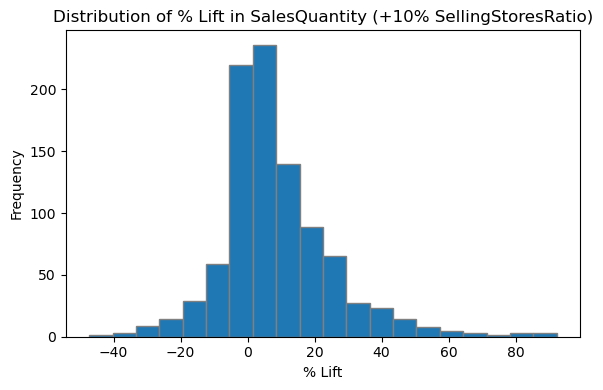

In [10]:
# Optional: quick visual
plt.figure(figsize=(6,4))
plt.hist(pct_change.dropna(), bins=20, edgecolor="gray")
plt.title("Distribution of % Lift in SalesQuantity (+10% SellingStoresRatio)")
plt.xlabel("% Lift")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [11]:
# CHECK LIFTS BY SUB-CATEGORY

#  1: Identify the sub-category dummy columns ---
subcat_cols = [c for c in X_test.columns if c.startswith("S_")]
print("Sub-category columns detected:", subcat_cols)

#  2: Map each row to its active sub-category 
# (Each row should have a 1 in exactly one dummy variable)
subcat_map = X_test[subcat_cols].idxmax(axis=1)

#  3: Combine sub-category info with lift summary
summary_by_sub = summary.copy()
summary_by_sub["SubCategory"] = subcat_map

#  4: Group and compute mean lift metrics
lift_by_sub = (
    summary_by_sub.groupby("SubCategory")[["Abs_Lift", "Pct_Lift"]]
    .mean()
    .sort_values("Abs_Lift", ascending=False)
    .reset_index()
)

print("=== Average Lift by Sub-Category (SellingStoresRatio +10%) ===")
print(lift_by_sub.round(2))


Sub-category columns detected: ['S_8qIm', 'S_Aunz', 'S_Mm5P', 'S_OzTP', 'S_UIpu', 'S_WeHS', 'S_qE16', 'S_sldf', 'S_xdDe', 'S_yo2Z']
=== Average Lift by Sub-Category (SellingStoresRatio +10%) ===
  SubCategory  Abs_Lift  Pct_Lift
0      S_WeHS      7.69     14.34
1      S_qE16      4.53     11.79
2      S_Mm5P      4.31      9.90
3      S_sldf      2.96      8.82
4      S_xdDe      2.70     10.31
5      S_UIpu      2.61      7.85
6      S_Aunz      2.20      6.96
7      S_8qIm      1.71      7.70
8      S_OzTP      1.31      6.76
9      S_yo2Z      0.06      3.11


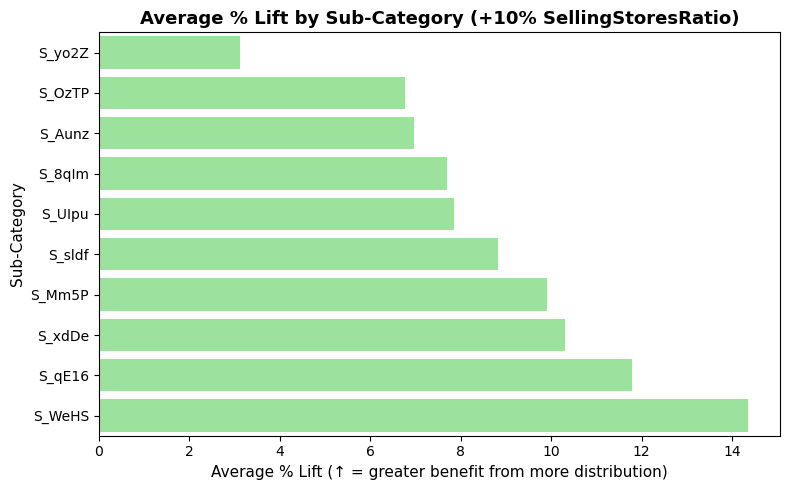

In [12]:
# visualize
import seaborn as sns

# Sort by Pct_Lift ascending for ranked display
lift_by_sub_sorted = lift_by_sub.sort_values("Pct_Lift", ascending=True)

plt.figure(figsize=(8,5))
sns.barplot(
    data=lift_by_sub_sorted,
    x="Pct_Lift", 
    y="SubCategory", 
    color="lightgreen"
)
plt.title("Average % Lift by Sub-Category (+10% SellingStoresRatio)", fontsize=13, fontweight="bold")
plt.xlabel("Average % Lift (↑ = greater benefit from more distribution)", fontsize=11)
plt.ylabel("Sub-Category", fontsize=11)
plt.tight_layout()
plt.show()



### INSIGHTS FROM PREDICTION

#### Distribution
On average, a 10% increase in SellingStoresRatio (capped not to exceed 1.0) generates an 8.64% lift in SalesQuantity.  The distribution sensitive varies greatly by sub-category, with some registering lifts >10%, these are the sub-categories that must be prioritized.

In [13]:
# USE MODEL TO PREDICT IMPACT OF A -10% PRICE INCREASE

# --- Retrieve your trained Random Forest model ---
best_rf = models["RandomForest"].best_estimator_

# --- Get the fitted StandardScaler for NewBasePrice ---
# If you used `scaler` earlier, this will grab it; otherwise set price_scaler = your scaler
try:
    price_scaler
except NameError:
    # Fallback to a variable named `scaler` if that's what you used
    try:
        price_scaler = scaler
    except NameError:
        raise NameError(
            "Couldn't find a fitted scaler for NewBasePrice. "
            "Please ensure the same StandardScaler used during preprocessing is available as `price_scaler` or `scaler`."
        )

# --- Baseline predictions on current (already-standardized) X_test ---
y_pred_base = pd.Series(best_rf.predict(X_test), index=X_test.index, name="Pred_Base")

# --- Create modified dataset: +10% NewBasePrice on ORIGINAL scale, then re-standardize ---
X_test_down = X_test.copy()

# 1) Invert standardization: price_orig = price_scaler.inverse_transform(standardized_values)
price_std = X_test_down[["NewBasePrice"]].values  # shape (n,1)
price_orig = price_scaler.inverse_transform(price_std)  # back to original currency/units

# 2) Apply 10% price decrease
price_down_orig = price_orig * 0.90

# 3) Re-standardize with the SAME scaler fitted on TRAIN data
price_down_std = price_scaler.transform(price_down_orig)

# 4) Put the adjusted standardized prices back into the test features
X_test_down.loc[:, "NewBasePrice"] = price_down_std.ravel()

# --- Scenario predictions ---
y_pred_down = pd.Series(best_rf.predict(X_test_up), index=X_test.index, name="Pred_10pctPriceDown")

# --- Impact calculations ---
delta = (y_pred_down - y_pred_base).rename("Abs_Lift")  
pct_change = pd.Series(
    np.where(y_pred_base != 0, (delta / y_pred_base) * 100, np.nan),
    index=X_test.index, name="Pct_Lift"
)

# --- Summary table ---
summary = pd.concat([y_pred_base, y_pred_down, delta, pct_change], axis=1)

print("=== Impact Summary: -10% NewBasePrice (using original-scale change, re-standardized) ===")
print("Average Predicted SalesQuantity (Current):", round(y_pred_base.mean(), 2))
print("Average Predicted SalesQuantity (-10% Price):", round(y_pred_down.mean(), 2))
print("Average Absolute Change:", round(delta.mean(), 2))
print("Average % Change:", round(pct_change.mean(skipna=True), 2), "%")

=== Impact Summary: -10% NewBasePrice (using original-scale change, re-standardized) ===
Average Predicted SalesQuantity (Current): 35.21
Average Predicted SalesQuantity (-10% Price): 38.29
Average Absolute Change: 3.08
Average % Change: 8.64 %


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [14]:
print("\nTop 10 largest magnitude changes:")
print(summary.reindex(summary['Abs_Lift'].abs().sort_values(ascending=False).head(10).index))


Top 10 largest magnitude changes:
      Pred_Base  Pred_10pctPriceDown   Abs_Lift   Pct_Lift
675  200.210151           105.594170 -94.615982 -47.258334
615  154.862455           226.217977  71.355522  46.076709
345  166.175910           226.094761  59.918850  36.057483
127  174.833825           117.981606 -56.852219 -32.517860
621  239.909651           292.876281  52.966631  22.077741
177  179.936282           127.194782 -52.741501 -29.311209
758  190.361378           137.799023 -52.562355 -27.611880
596  129.444284            78.800345 -50.643938 -39.124121
902   57.464906           107.414041  49.949135  86.921111
698  156.087056           109.762601 -46.324455 -29.678601


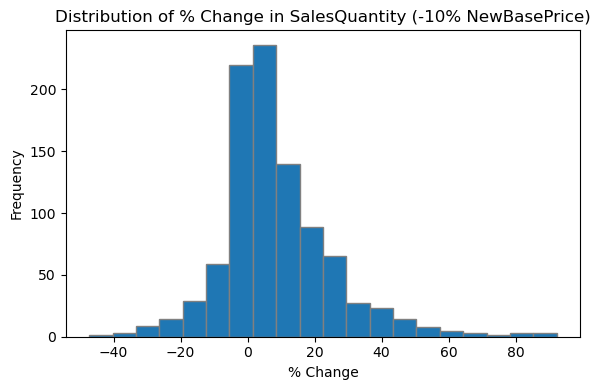

In [15]:
# Histogram of % change ---
plt.figure(figsize=(6,4))
plt.hist(pct_change.dropna(), bins=20, edgecolor="gray")
plt.title("Distribution of % Change in SalesQuantity (-10% NewBasePrice)")
plt.xlabel("% Change")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [16]:
# CHECK PRICE SENSITIVITY BY SUB-CATEGORY

#  1: Identify the sub-category dummy columns 
subcat_cols = [c for c in X_test.columns if c.startswith("S_")]
print("Sub-category columns detected:", subcat_cols)

# 2: Map each row to its active sub-category 
subcat_map = X_test[subcat_cols].idxmax(axis=1)

# 3: Combine sub-category info with lift summary
summary_by_sub = summary.copy()
summary_by_sub["SubCategory"] = subcat_map

#  4: Group and compute mean lift metrics 
lift_by_sub = (
    summary_by_sub.groupby("SubCategory")[["Pred_Base", "Pred_10pctPriceDown", "Abs_Lift", "Pct_Lift"]]
    .mean()
    .sort_values("Abs_Lift", ascending=True)  # price increase → expect negative lifts
    .reset_index()
)

print("=== Average Lift by Sub-Category (-10% NewBasePrice) ===")
print(lift_by_sub.round(2))


Sub-category columns detected: ['S_8qIm', 'S_Aunz', 'S_Mm5P', 'S_OzTP', 'S_UIpu', 'S_WeHS', 'S_qE16', 'S_sldf', 'S_xdDe', 'S_yo2Z']
=== Average Lift by Sub-Category (-10% NewBasePrice) ===
  SubCategory  Pred_Base  Pred_10pctPriceDown  Abs_Lift  Pct_Lift
0      S_yo2Z      28.08                28.13      0.06      3.11
1      S_OzTP      14.65                15.96      1.31      6.76
2      S_8qIm      20.72                22.43      1.71      7.70
3      S_Aunz      44.99                47.20      2.20      6.96
4      S_UIpu      23.28                25.89      2.61      7.85
5      S_xdDe      29.46                32.16      2.70     10.31
6      S_sldf      32.40                35.35      2.96      8.82
7      S_Mm5P      38.35                42.67      4.31      9.90
8      S_qE16      42.50                47.03      4.53     11.79
9      S_WeHS      44.69                52.37      7.69     14.34


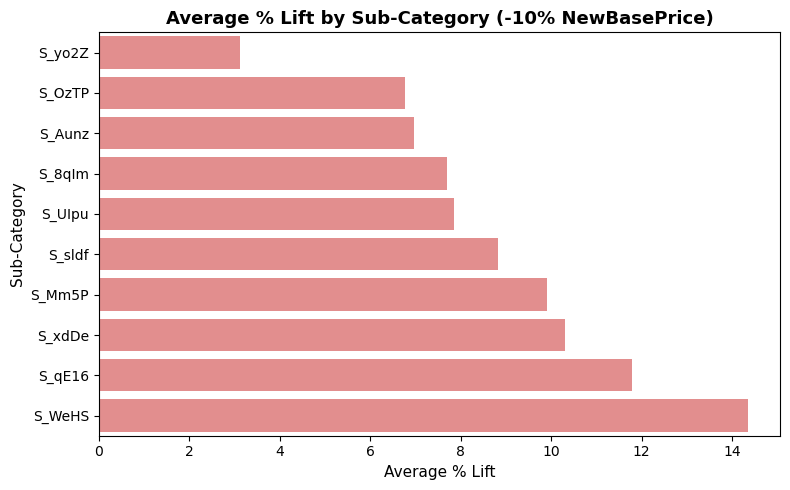

In [17]:
# visualization: % Lift by category

# Sort data before plotting so that bars are ordered by Pct_Lift ascending
lift_by_sub_sorted = lift_by_sub.sort_values("Pct_Lift", ascending=True)

plt.figure(figsize=(8,5))
sns.barplot(
    data=lift_by_sub_sorted,
    x="Pct_Lift", y="SubCategory",
    color="lightcoral"
)
plt.title("Average % Lift by Sub-Category (-10% NewBasePrice)", fontsize=13, fontweight="bold")
plt.xlabel("Average % Lift", fontsize=11)
plt.ylabel("Sub-Category", fontsize=11)
plt.tight_layout()
plt.show()


### INSIGHTS FROM PREDICTION

#### Pricing
On average, a 10% price decrease generates an 7.92% lift in SalesQuantity.  
This suggests the a loss in absolute dollar revenues 
(as increase in quantity is not enough to offest the decrease in price)

However, some sub-categories are more sensitive than others.
Recommend pricing action be taken in sub-categories where a 
10% price decrease generates 12% increase in SalesQuantity.

## OPTIONAL - FINE TUNING HYPER PARAMETERS DID NOT RESULT TO SIGNIFICANTLY HIGHER Test R2 and MAE

Random Forest model above:  r2_test = .731266      MAE = 10.775594
Tuning:
Randomized search:          r2_test = .734507      MAE = 10.62336
GridSearch:                 r2_test = .733462      MAE = 10.593079


In [17]:
# === Refined Random Forest Tuning ============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Ensure y is 1D ----------------------------------------------------------
def _to_1d(y):
    if isinstance(y, pd.DataFrame):
        if y.shape[1] == 1:
            return y.iloc[:, 0]
        else:
            raise ValueError("y has multiple columns; please provide a single target column.")
    return y.squeeze()

y_train_1d = _to_1d(y_train)
y_test_1d  = _to_1d(y_test)

# --- Config ------------------------------------------------------------------
RANDOM_STATE = 42
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
SCORING = "neg_root_mean_squared_error"

# --- Helper: evaluation -------------------------------------------------------
def evaluate(model, X_tr, y_tr, X_te, y_te, label="Model"):
    yhat_tr = model.predict(X_tr)
    yhat_te = model.predict(X_te)
    res = {
        "model": label,
        "rmse_train": mean_squared_error(y_tr, yhat_tr, squared=False),
        "rmse_test":  mean_squared_error(y_te, yhat_te, squared=False),
        "mae_train":  mean_absolute_error(y_tr, yhat_tr),
        "mae_test":   mean_absolute_error(y_te, yhat_te),
        "r2_train":   r2_score(y_tr, yhat_tr),
        "r2_test":    r2_score(y_te, yhat_te),
    }
    print(pd.Series(res).round(4).to_string())
    return res

# === 1) Broad Randomized Search =============================================
rf_base = RandomForestRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bootstrap=True # keep True to allow OOB in later diagnostics if desired
)

# Broad but sensible distributions
rand_dist = {
    "n_estimators": np.arange(200, 1201),             # 200–1200
    "max_depth":    [None] + list(np.arange(4, 41)),  # None or 4–40
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf":  [1, 2, 3, 4, 5, 10],
    "max_features": ["sqrt", "log2", 0.5, 0.7, 0.9],  # fraction of features or strategies
    "max_samples":  [None, 0.6, 0.7, 0.8, 0.9],       # row subsampling (requires bootstrap=True)
}

rand_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rand_dist,
    n_iter=60,                # increase to 100+ if you have time
    scoring=SCORING,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

print("\n>>> Running RandomizedSearchCV (broad sweep)...")
rand_search.fit(X_train, y_train_1d)
best_rand = rand_search.best_estimator_
print("\nBest (Randomized) params:\n", rand_search.best_params_)
print("Best (Randomized) CV score (neg RMSE):", round(rand_search.best_score_, 4))

_ = evaluate(best_rand, X_train, y_train_1d, X_test, y_test_1d, label="RF - RandomizedSearch best")

# === 2) Tight Grid around the randomized best ================================
best_params = rand_search.best_params_

def around_int(val, low=1, step=1, extra=None):
    if val is None: 
        return [None]
    cand = sorted(set([max(low, val - step), val, val + step]))
    if extra is not None:
        cand += extra
    return sorted(set([c for c in cand if c is None or c >= low]))

def around_float(val, step=0.1, bounds=(0.1, 1.0)):
    if isinstance(val, (float, np.floating)):
        a = max(bounds[0], round(val - step, 2))
        b = val
        c = min(bounds[1], round(val + step, 2))
        return sorted(set([a, b, c]))
    # if categorical like 'sqrt', 'log2' keep as is
    return [val]

grid = {
    "n_estimators": sorted(set([
        max(100, best_params["n_estimators"] - 200),
        best_params["n_estimators"],
        min(1500, best_params["n_estimators"] + 200)
    ])),
    "max_depth": ([None] if best_params["max_depth"] is None 
                  else around_int(best_params["max_depth"], low=2, step=3) + [None]),
    "min_samples_split": around_int(best_params["min_samples_split"], low=2, step=3, extra=[2,5,10]),
    "min_samples_leaf":  around_int(best_params["min_samples_leaf"],  low=1, step=2, extra=[1,2,3,5]),
    "max_features":      around_float(best_params["max_features"]) if isinstance(best_params["max_features"], (float, np.floating))
                         else [best_params["max_features"], "sqrt", "log2"],
    "max_samples":       ([None] if best_params["max_samples"] is None 
                          else around_float(best_params["max_samples"], step=0.1, bounds=(0.5, 1.0)) + [None]),
}

# Remove duplicates and clean lists
for k,v in grid.items():
    # remove potential duplicates while preserving order
    seen, cleaned = set(), []
    for item in v:
        if item not in seen:
            cleaned.append(item); seen.add(item)
    grid[k] = cleaned

print("\nFocused Grid built around randomized best:")
for k, v in grid.items():
    print(f"  {k}: {v}")

rf_focus = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1, bootstrap=True)

grid_search = GridSearchCV(
    estimator=rf_focus,
    param_grid=grid,
    scoring=SCORING,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\n>>> Running GridSearchCV (focused refinement)...")
grid_search.fit(X_train, y_train_1d)
best_grid = grid_search.best_estimator_

print("\nBest (Grid) params:\n", grid_search.best_params_)
print("Best (Grid) CV score (neg RMSE):", round(grid_search.best_score_, 4))

final_metrics = evaluate(best_grid, X_train, y_train_1d, X_test, y_test_1d, label="RF - GridSearch best")

# --- Optional: save/use the final tuned RF -----------------------------------
best_rf_tuned = best_grid  # <- this is your final tuned model



>>> Running RandomizedSearchCV (broad sweep)...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best (Randomized) params:
 {'n_estimators': 699, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt', 'max_depth': 25}
Best (Randomized) CV score (neg RMSE): -23.2908
model         RF - RandomizedSearch best
rmse_train                     12.747063
rmse_test                      29.007341
mae_train                       5.819117
mae_test                        10.62336
r2_train                        0.941292
r2_test                         0.734607

Focused Grid built around randomized best:
  n_estimators: [499, 699, 899]
  max_depth: [22, 25, 28, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 3, 5]
  max_features: ['sqrt', 'log2']
  max_samples: [0.5, 0.6, 0.7, None]

>>> Running GridSearchCV (focused refinement)...
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best (Grid) params:
 {'max_depth': 22, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 699}
Best (Grid) CV score (neg RMSE): -23.2427
model         RF - GridSearch best
rmse_train               11.639817
rmse_test                29.042605
mae_train                 5.328732
mae_test                 10.593079
r2_train                  0.951048
r2_test                   0.733962


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
